<a href="https://colab.research.google.com/github/dinarasaurae/pyad-2024/blob/lr3/%D0%A5%D0%B8%D1%81%D0%B0%D0%BC%D0%B5%D1%82%D0%B4%D0%B8%D0%BD%D0%BE%D0%B2%D0%B0_%D0%94%D0%B8%D0%BD%D0%B0%D1%80%D0%B0_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_1_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Добавила немного теории, которой я пользовалась дополнительно (из презентации в лисе)
## Дообучение классификатора на ResNet50

Точность на Imagenet меньше 70%

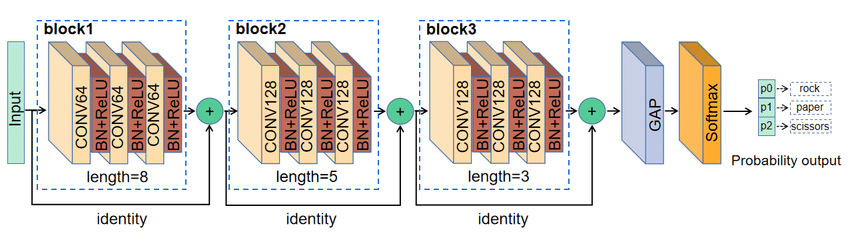

Почитать про ResNet: https://arxiv.org/abs/1512.03385

**ResNet** — это сокращенное название для Residual Network (дословно  — «остаточная сеть»), но что такое residual learning («остаточное обучение»)?

Глубокие сети извлекают низко-, средне- и высокоуровневые признаки  сквозным многослойным способом, а увеличение количества stacked layers может обогатить «уровни» признаков.

Когда более глубокая сеть начинает сворачиваться, возникает проблема: с увеличением глубины сети точность сначала увеличивается, а затем быстро ухудшается. Снижение точности обучения показывает, что не все сети легко оптимизировать.

Чтобы преодолеть эту проблему, Microsoft ввела глубокую «остаточную» структуру обучения. Вместо того, чтобы надеяться на то, что каждые несколько stacked layers непосредственно соответствуют желаемому основному представлению, они явно позволяют этим слоям соответствовать «остаточному». Формулировка $F(x) + x$ может быть реализована с помощью нейронных сетей с соединениями для быстрого доступа.

Соединения быстрого доступа (shortcut connections) пропускают один или несколько слоев и выполняют сопоставление идентификаторов. Их выходы добавляются к выходам stacked layers. Используя ResNet, можно решить множество проблем, таких как:

- ResNet относительно легко оптимизировать: «простые» сети (которые просто складывают слои) показывают большую ошибку обучения, когда глубина увеличивается.
- ResNet позволяет относительно легко увеличить точность благодаря увеличению глубины, чего с другими сетями добиться сложнее.

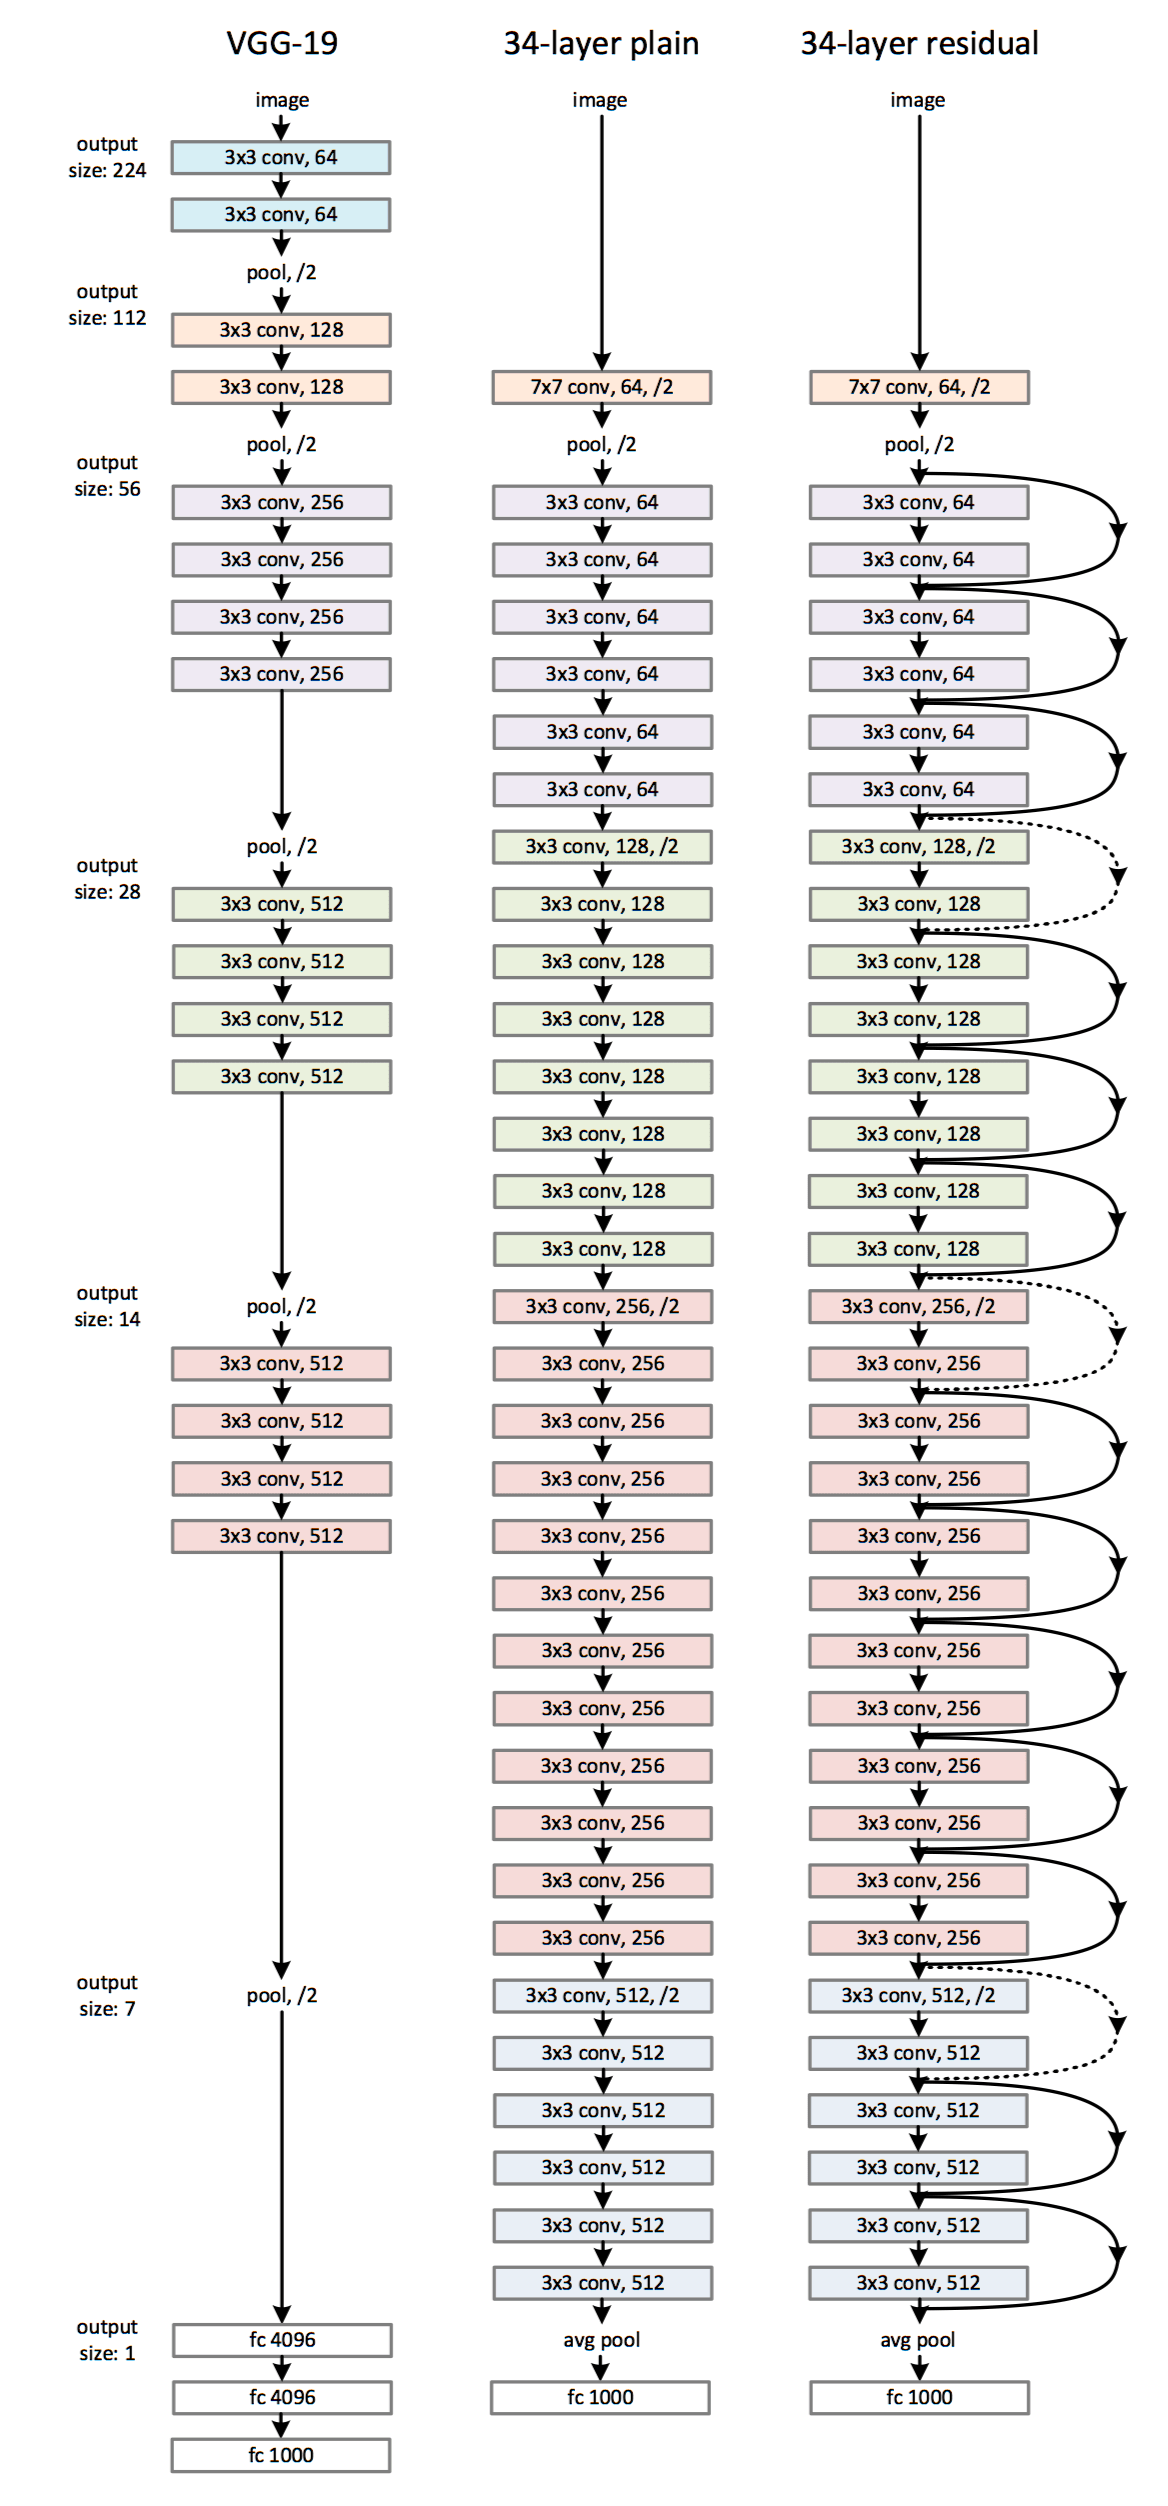



**Простая сеть:** Простые базовые линии (рис. 2, в центре) в основном вдохновлены философией сетей VGG (рис. 2, слева). Сверточные слои в основном имеют фильтры 3×3 и следуют двум простым правилам:

- Для одной и той же выходной карты объектов слои имеют одинаковое количество фильтров;
- Если размер карты объектов уменьшается вдвое, число фильтров удваивается, чтобы сохранить временную сложность каждого слоя.

Стоит отметить, что модель ResNet имеет меньше фильтров и сложность меньше, чем сети VGG.

**ResNet:** на основе описанной выше простой сети добавлено быстрое соединение (рис. 2, справа), которое превращает сеть в ее остаточную версию. Идентификационные быстрые соединения $F (x {W} + x)$ могут использоваться непосредственно, когда вход и выход имеют одинаковые размерности (быстрые соединения сплошной линии на рис. 2). Когда размерности увеличиваются (пунктирные линии на рис. 2), он рассматривает два варианта:

1. Быстрое соединение выполняет сопоставление идентификаторов с дополнительными нулями, добавленными для увеличения размерности. Эта опция не вводит никаких дополнительных параметров.
2. Проекция быстрого соединения  в $F(x {W} + x)$ используется для сопоставления размерностей (выполнено с помощью 1×1 сверток).
Для любой из опций, если быстрые соединения идут по картам объектов двух размерностей, они выполняются с шагом 2.

## Был взят набор данных для классификации изображения на два класса - собака или кошка

In [ ]:
import kagglehub

path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")

print("Path to dataset files:", path)

100%|██████████| 788M/788M [00:36<00:00, 22.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1


In [ ]:
!cd /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Cat && ls

0.jpg	   11250.jpg  1250.jpg	2500.jpg  3751.jpg  5000.jpg  6251.jpg	7501.jpg  8752.jpg
10000.jpg  11251.jpg  1251.jpg	2501.jpg  3752.jpg  5001.jpg  6252.jpg	7502.jpg  8753.jpg
10001.jpg  11252.jpg  1252.jpg	2502.jpg  3753.jpg  5002.jpg  6253.jpg	7503.jpg  8754.jpg
10002.jpg  11253.jpg  1253.jpg	2503.jpg  3754.jpg  5003.jpg  6254.jpg	7504.jpg  8755.jpg
10003.jpg  11254.jpg  1254.jpg	2504.jpg  3755.jpg  5004.jpg  6255.jpg	7505.jpg  8756.jpg
10004.jpg  11255.jpg  1255.jpg	2505.jpg  3756.jpg  5005.jpg  6256.jpg	7506.jpg  8757.jpg
10005.jpg  11256.jpg  1256.jpg	2506.jpg  3757.jpg  5006.jpg  6257.jpg	7507.jpg  8758.jpg
10006.jpg  11257.jpg  1257.jpg	2507.jpg  3758.jpg  5007.jpg  6258.jpg	7508.jpg  8759.jpg
10007.jpg  11258.jpg  1258.jpg	2508.jpg  3759.jpg  5008.jpg  6259.jpg	7509.jpg  875.jpg
10008.jpg  11259.jpg  1259.jpg	2509.jpg  375.jpg   5009.jpg  625.jpg	750.jpg   8760.jpg
10009.jpg  1125.jpg   125.jpg	250.jpg   3760.jpg  500.jpg   6260.jpg	7510.jpg  8761.jpg
1000.jpg   11260.jpg  1260

In [ ]:
BATCH_SIZE=64

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from PIL import Image
from sklearn.metrics import f1_score
import os

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.dataset = ImageFolder(img_dir, transform=transform)
        self.valid_indices = self._filter_valid_images()

    def _filter_valid_images(self):
        valid_indices = []
        for idx in range(len(self.dataset)):
            try:
                img, _ = self.dataset[idx]
                valid_indices.append(idx)
            except Exception as e:
                print(f"пропускаю поврежденные файлы: {self.dataset.imgs[idx][0]}, Error: {e}")
        return valid_indices

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        return self.dataset[actual_idx]


Преобразования изображений для ResNet50

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
img_dir = '/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages'

dataset = CustomImageDataset(img_dir, transform=transform)

Skipping corrupted or invalid file: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Cat/666.jpg, Error: cannot identify image file <_io.BufferedReader name='/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Cat/666.jpg'>
Skipping corrupted or invalid file: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog/11702.jpg, Error: cannot identify image file <_io.BufferedReader name='/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog/11702.jpg'>


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Тренирую как обычно 80/20

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Меняю последний слой, чтобы он соответствовал числу классов (2: коты и собаки)

In [ ]:
model = models.resnet50(pretrained=True)

num_classes = len(dataset.dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model.fc

Linear(in_features=2048, out_features=2, bias=True)

Функция вычисления F1-меры на тестовых данных

In [ ]:
def calculate_f1_score(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return f1_score(y_true, y_pred, average='weighted')

In [ ]:
num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_dataloader)}')

    f1 = calculate_f1_score(model, test_dataloader, device)
    print(f'Epoch {epoch+1}/{num_epochs}, F1 Score: {f1:.4f}')

print('Training complete')


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/2, Loss: 0.7099199295997619
Epoch 1/2, F1 Score: 0.4555


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 2/2, Loss: 0.709999175453186
Epoch 2/2, F1 Score: 0.4501
Training complete


# Вывод
Использована кастомная обработка изображений: отфильтрованы поврежденные файлы, что помогло избежать ошибок при загрузке.
Применена стандартная предобработка для работы с ResNet50: изменение размера до 224x224, нормализация пикселей и преобразование в тензоры.

В качестве основы взята ResNet50, известная высокой точностью в задачах классификации изображений.

Использованы предобученные веса (transfer learning), что дало хорошее начальное приближение, ускорив процесс обучения.

Финальный полносвязный слой заменен на nn.Linear(2048, 2), чтобы адаптировать модель к задаче бинарной классификации.

Выбраны CrossEntropyLoss (оптимальная функция потерь для классификации) и Adam (современный оптимизатор с автоматической адаптацией скорости обучения).

За 2 эпохи удалось существенно уменьшить ошибку модели, что свидетельствует о правильной настройке процесса.

Средняя потеря (Loss) осталась стабильной (~0.71), что показывает, что модель не переобучается и не "запоминает" данные.